In [23]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection
import plotly.express as px

print(sns.__version__)
# Save a palette to a variable:
palette = sns.color_palette("bright")

sns.set_palette(palette)
sns.set(style="whitegrid", font_scale=2.5)


colors = ["#fc8d59", "#d73027", "#2e88df", "#762a81", "#99d594", "#3288bd"]
palette = sns.color_palette(colors, as_cmap=True)


seed = 1823492

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.12.2


# corona

<div class="alert alert-block alert-info">
<h2> Clustering of outliers </h2>
</div>

In [12]:
PROCESSED_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/"
study = "corona"
freq = "4epochs"
method = "si"
threshold = 2.5
with open(f"../config/features.txt") as f:
    features = json.load(f)

FEATURES = features[study][freq]
baseline_diff_df = pd.read_csv(
    f"{PROCESSED_PATH}/{freq}_{method}_threshold_{threshold}_diff_baseline.csv"
)

# Get outlier
outliers = baseline_diff_df.query("outlier == True")
len(outliers)

149

In [13]:
from sklearn.metrics import silhouette_score

# Determine optimal cluster number with elbow method
wcss = []

silhouette_scores = []
for i in range(2, 11):
    model = KMeans(
        n_clusters=i,
        init="k-means++",  # Initialization method for kmeans
        max_iter=300,  # Maximum number of iterations
        n_init=10,  # Choose how often algorithm will run with different centroid
        random_state=0,
    )  # Choose random state for reproducibility
    labels = model.fit_predict(outliers[FEATURES])

    # Silhouette Index
    silhouette_avg = silhouette_score(outliers[FEATURES], labels)
    silhouette_scores.append(silhouette_avg)

# Determine optimal cluster number using maximum Silhouette score and maximum Dunn index
optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
print("Optimal num cluster: ", optimal_clusters_silhouette)

Optimal num cluster:  5


In [14]:
kmeans = KMeans(
    n_clusters=optimal_clusters_silhouette,  # Set amount of clusters
    init="k-means++",  # Initialization method for kmeans
    max_iter=300,  # Maximum number of iterations
    n_init=10,  # Choose how often algorithm will run with different centroid
    random_state=seed,
)  # Choose random state for reproducibility

pred_y = kmeans.fit_predict(outliers[FEATURES])

outliers["outlier_cluster"] = kmeans.labels_ + 1
outliers.groupby("outlier_cluster").median()

/share/apps/anaconda-ci/fgci-centos7-generic/software/anaconda/2020-03-tf1/f43b17a3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,heart_rate_variability_avg:norm,stepsx1000:total:norm,steps:night:norm,steps:morning:norm,steps:afternoon:norm,steps:evening:norm,tst:norm,midsleep:norm,subject_id,sim_to_baseline,outlier
outlier_cluster,,,,,,,,,,,
1,0.634921,0.065924,0.001190,0.040864,0.005032,-0.109208,-0.088474,-0.045026,2231335370,0.517837,True
2,0.078858,-0.216836,-0.000814,-0.178794,-0.418631,0.609913,0.115044,0.122796,2336729904,0.488748,True
3,-0.054791,-0.337772,0.002430,0.726145,-0.385058,-0.344152,-0.033962,-0.043742,2468416326,0.493059,True
4,-0.105751,-0.324216,0.954935,-0.218477,-0.411674,-0.266237,-0.080688,-0.003074,1979149348,0.449150,True
5,-0.233766,0.226316,0.299224,-0.157482,-0.088021,-0.137413,-0.265460,0.608935,1834992216,0.492822,True


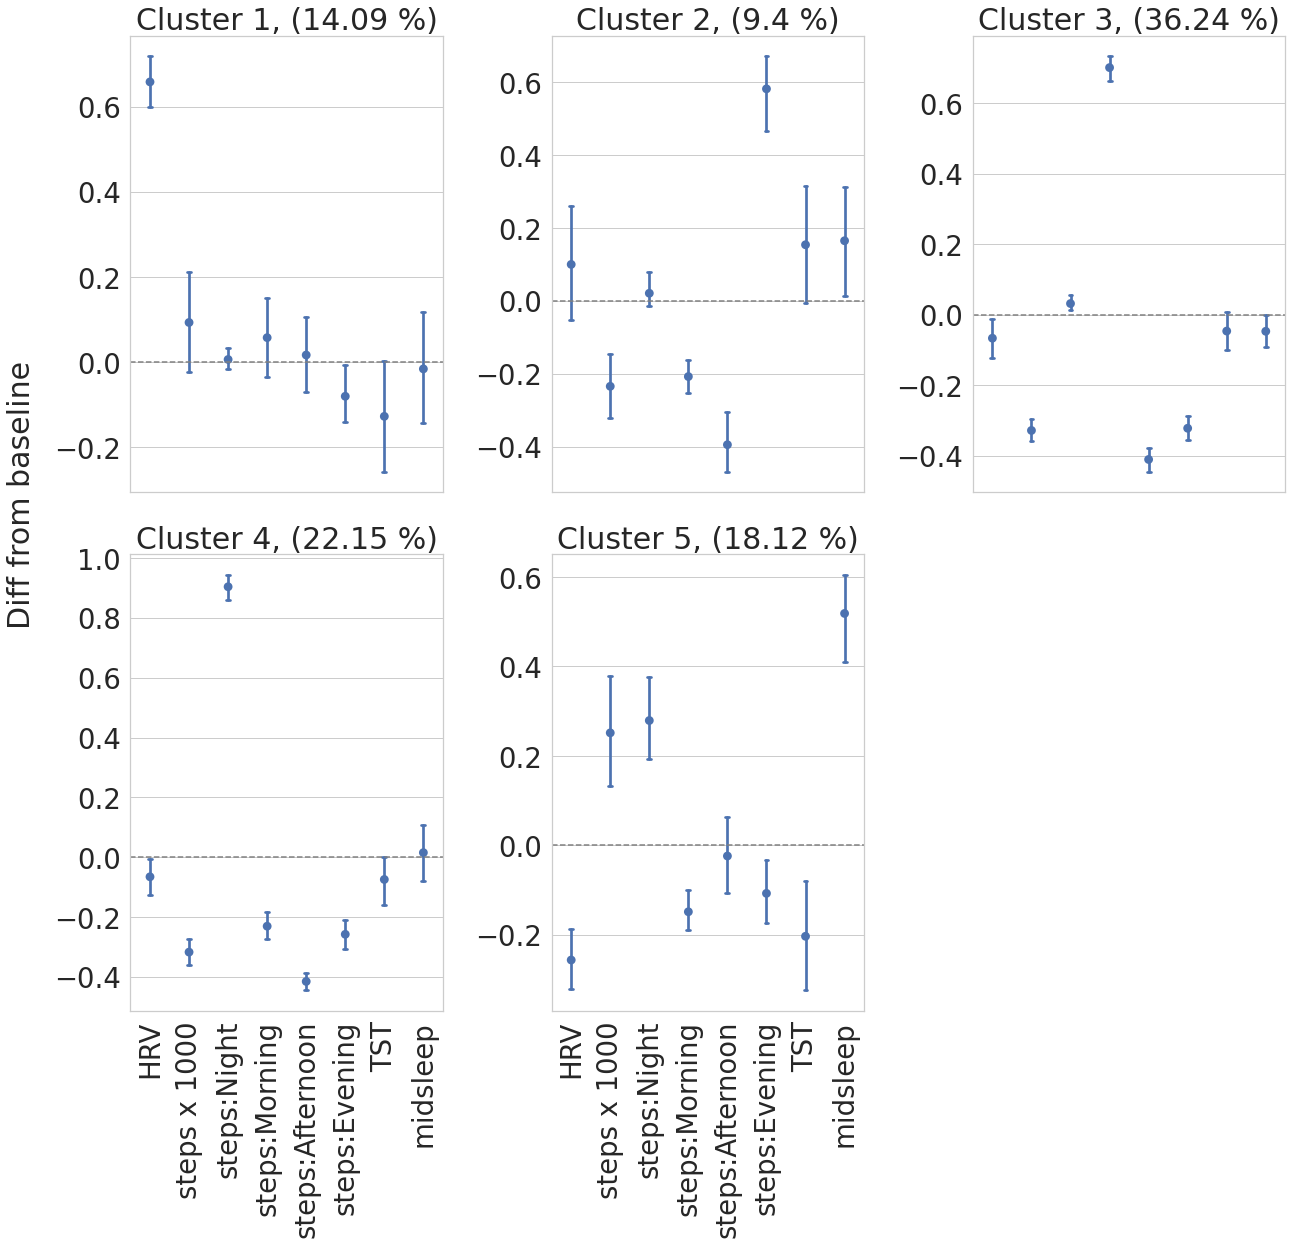

In [28]:
pivot_outliers = pd.melt(outliers, id_vars="outlier_cluster", value_vars=FEATURES)
pivot_outliers["label"] = pivot_outliers["variable"].map(
    {
        "heart_rate_variability_avg:norm": "HRV",
        "stepsx1000:total:norm": "steps x 1000",
        "steps:night:norm": "steps:Night",
        "steps:morning:norm": "steps:Morning",
        "steps:afternoon:norm": "steps:Afternoon",
        "steps:evening:norm": "steps:Evening",
        "tst:norm": "TST",
        "midsleep:norm": "midsleep",
    }
)

# Get unique clusters
clusters = pivot_outliers["outlier_cluster"].unique()

# Set up the matplotlib figure with 2 columns and 3 rows, sharing x-axis

num_clusters = len(clusters)
columns = 3
rows = (
    (num_clusters + 1) // columns if num_clusters % columns else num_clusters // columns
)

# Create the subplots
fig, axes = plt.subplots(rows, columns, figsize=(18, 18), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through clusters and create a point plot for each
for i, cluster in enumerate(sorted(clusters)):
    # Filter data for the current cluster
    cluster_data = pivot_outliers[pivot_outliers["outlier_cluster"] == cluster]

    # Create pointplot
    sns.pointplot(
        x="label", y="value", data=cluster_data, capsize=0.1, join=False, ax=axes[i]
    )

    # Add horizontal line at y=0
    axes[i].axhline(0, color="gray", linestyle="--")

    # Set the title to the current cluster
    axes[i].set_title(
        f"Cluster {cluster}, ({np.round(len(cluster_data) / len(pivot_outliers) * 100, 2)} %)"
    )

    # Remove the y-axis label
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Improve readability for x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="center")

# Set a common x-axis label
fig.text(0.0, 0.5, "Diff from baseline", ha="center", rotation=90, size=30)

# Hide any unused subplots if the number of clusters is less than the number of subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
fig.savefig("cluster_outliers.png", dpi=300, bbox_inches="tight")
plt.show()

 Explained vairance:  [0.3382768  0.2252625  0.15003016 0.11250281]
Loading: 
                                       PC1       PC2       PC3       PC4
heart_rate_variability_avg:norm  0.062728  0.404992  0.640597 -0.353618
stepsx1000:total:norm           -0.241807  0.465198 -0.229427 -0.239351
steps:night:norm                -0.421220 -0.623383  0.154333 -0.267976
steps:morning:norm               0.776063 -0.023959 -0.250949 -0.071181
steps:afternoon:norm            -0.151914  0.337328 -0.115883 -0.300865
steps:evening:norm              -0.202929  0.310014  0.212500  0.640022
tst:norm                         0.096498 -0.073718  0.278330  0.455216
midsleep:norm                   -0.290387  0.122714 -0.560492  0.182807


/share/apps/anaconda-ci/fgci-centos7-generic/software/anaconda/2020-03-tf1/f43b17a3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.


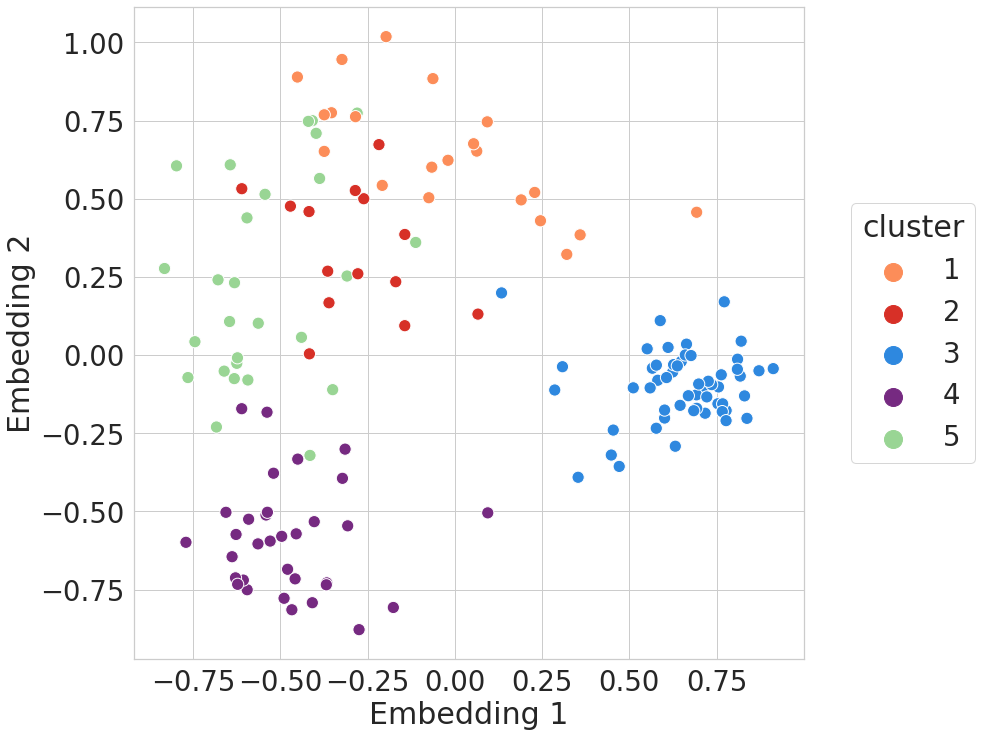

In [29]:
from sklearn.decomposition import PCA

# PCA on meandiff
pca = PCA(n_components=4, svd_solver="full")
X = outliers[FEATURES]
X_pca = pca.fit_transform(X)
# X_pca['cluster'] = mean_diff['cluster']
print(" Explained vairance: ", pca.explained_variance_ratio_)

# Loading
loadings = pd.DataFrame(
    pca.components_.T, columns=["PC1", "PC2", "PC3", "PC4"], index=FEATURES
)
print("Loading: \n", loadings)

# Viz


def plot_embedding(X, title):
    fig = plt.figure(figsize=(12, 12))
    g = sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=outliers["outlier_cluster"],
        palette=palette,
        s=150,
    )
    #    fig = px.scatter_3d(X, x=X[:, 0], y=X[:, 1], z=X[:, 2], color = mean_diff["cluster"], width=1000, height=1000,
    #                       color_discrete_sequence=px.colors.qualitative.Set2)
    g.legend(
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        ncol=1,
        markerscale=3,
        title="cluster",
    )
    g.set_xlabel("Embedding 1")
    g.set_ylabel("Embedding 2")
    return g


# px.scatter_3d(X, x=X[:, 0], y=X[:, 1], z=X[:, 2], color = mean_diff["cluster"])
fig = plot_embedding(X_pca, "PCA")
plt.savefig("tsne_embedding.png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
outliers

,heart_rate_variability_avg:norm,stepsx1000:total:norm,steps:night:norm,steps:morning:norm,steps:afternoon:norm,steps:evening:norm,tst:norm,midsleep:norm,subject_id,date,sim_to_baseline,outlier,outlier_cluster
499,-0.325000,-0.441774,0.963702,-0.059514,-0.345755,-0.558433,0.034884,-0.050844,3671581472,2022-03-02,0.436375,True,4
675,-0.002442,-0.355783,0.000906,0.589424,-0.348099,-0.242230,0.211691,-0.177106,3609986162,2021-09-12,0.539252,True,3
807,-0.079365,-0.513491,0.065891,0.593582,-0.403466,-0.256007,0.142857,-0.049676,3609986162,2022-01-29,0.516279,True,3
902,0.766789,-0.183760,-0.011115,0.294195,-0.070726,-0.212354,-0.099973,0.166307,3609986162,2022-05-14,0.528464,True,1
1178,-0.261905,-0.344318,0.004934,-0.325149,-0.430630,0.750845,0.394621,0.108150,4015483950,2022-02-13,0.476239,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24931,0.077482,-0.235449,-0.034891,0.815712,-0.330661,-0.450160,-0.249391,0.502702,2038129448,2022-01-04,0.462104,True,3
25199,0.117460,-0.582361,0.989987,-0.226890,-0.481272,-0.281825,-0.296623,-0.233251,1797581562,2021-12-07,0.424501,True,4
25812,0.792517,-0.282515,0.001712,0.160181,0.098787,-0.260680,-0.102577,-0.045026,310966998,2021-11-19,0.524206,True,1
26020,-0.162021,-0.447612,0.261477,0.581012,-0.451769,-0.390720,-0.042498,0.065801,1076660686,2021-11-06,0.500571,True,3
